# Solution 2: Evaluating a decision tree

This notebook is a solution to the problem posed in [exercises/exercise-2.ipynb](../exercises/exercise-2.ipynb).

Don't peek at this until you've tried to solve it!

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.tree
import matplotlib
import matplotlib.pyplot as plt

In [2]:
X1, y1 = sklearn.datasets.make_gaussian_quantiles(
    cov=2.0, n_samples=500, n_features=2, n_classes=2, random_state=1
)
X2, y2 = sklearn.datasets.make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=1000, n_features=2, n_classes=2, random_state=1
)

X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

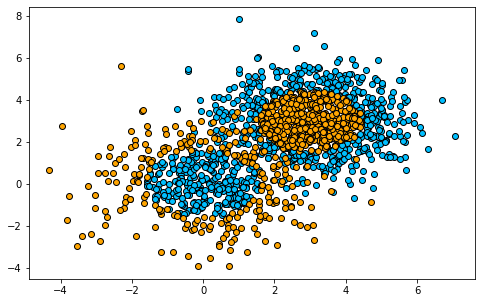

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black");
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black");

In [4]:
decision_tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)
decision_tree.fit(X, y)

DecisionTreeClassifier(max_depth=10)

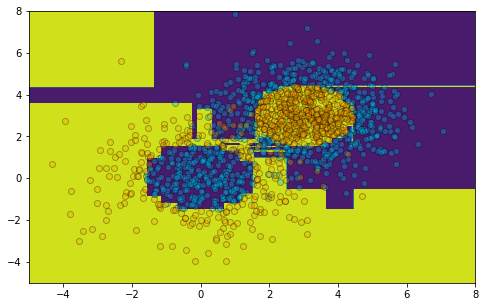

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))
Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

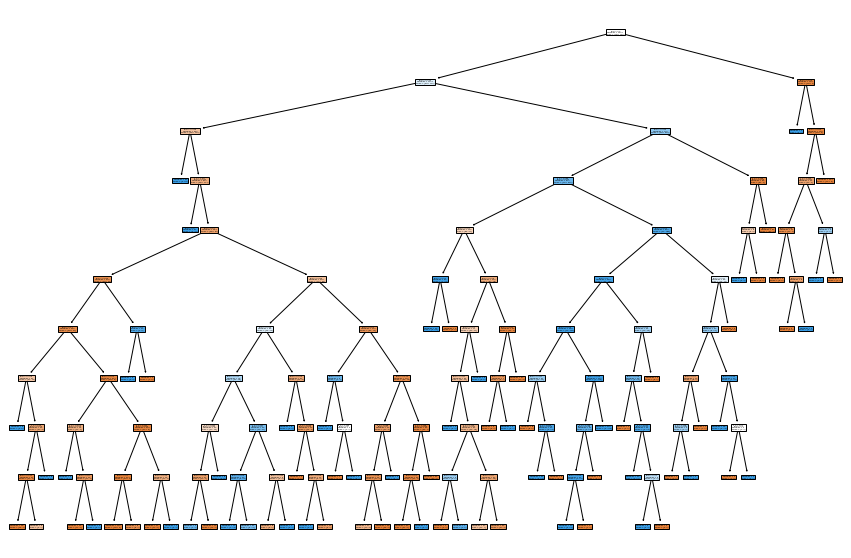

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

sklearn.tree.plot_tree(decision_tree, feature_names=["x", "y"], filled=True, ax=ax);

In [7]:
def print_tree(tree, array_index=0, indent="", feature_names=["x", "y"]):
    has_children = tree.children_left[array_index] >= 0

    if has_children:
        feature = tree.feature[array_index]
        threshold = tree.threshold[array_index]
        left_index = tree.children_left[array_index]
        right_index = tree.children_right[array_index]

        yield f"{indent}{feature_names[feature]} <= {threshold:.2f}"
        yield from print_tree(tree, left_index, indent + "    ", feature_names)

        yield f"{indent}{feature_names[feature]} > {threshold:.2f}"
        yield from print_tree(tree, right_index, indent + "    ", feature_names)

    else:
        winner = np.argmax(tree.value[array_index])

        yield f"{indent}class: {winner}"

In [8]:
for mine, theirs in zip(
    print_tree(decision_tree.tree_),
    sklearn.tree.export_text(decision_tree, feature_names=["x", "y"]).split("\n"),
):
    print(f"{mine:60s} {theirs:60s}")

y <= 4.37                                                    |--- y <= 4.37                                              
    y <= 1.72                                                |   |--- y <= 1.72                                          
        y <= -1.48                                           |   |   |--- y <= -1.48                                     
            class: 1                                         |   |   |   |--- class: 1                                   
        y > -1.48                                            |   |   |--- y >  -1.48                                     
            x <= -1.58                                       |   |   |   |--- x <= -1.58                                 
                class: 1                                     |   |   |   |   |--- class: 1                               
            x > -1.58                                        |   |   |   |--- x >  -1.58                                 
                x <= 1.1

In [9]:
decision_tree.predict([[0, 0]])

array([0])

In [10]:
def predict_single(position, tree, array_index=0):
    has_children = tree.children_left[array_index] >= 0

    if has_children:
        feature = tree.feature[array_index]
        threshold = tree.threshold[array_index]
        left_index = tree.children_left[array_index]
        right_index = tree.children_right[array_index]

        if position[feature] <= threshold:
            return predict_single(position, tree, left_index)
        else:
            return predict_single(position, tree, right_index)

    else:
        return np.argmax(tree.value[array_index], axis=1)

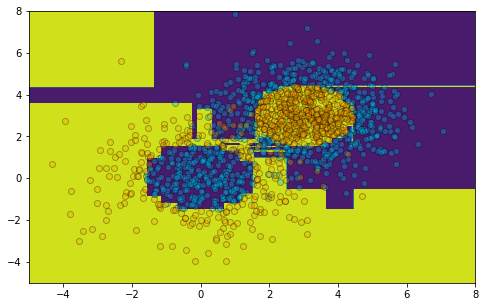

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    [predict_single(position, decision_tree.tree_) for position in np.c_[xx.ravel(), yy.ravel()]]
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

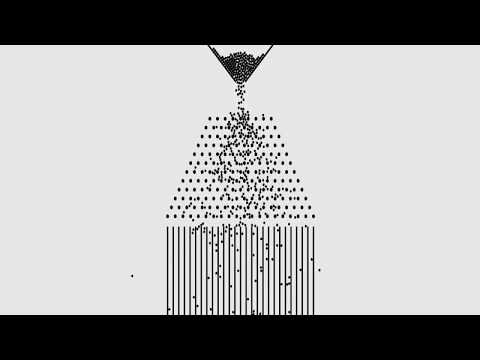

In [12]:
from IPython.display import YouTubeVideo

YouTubeVideo('AuEUAXlbE94', width=600, height=450)

In [13]:
def predict_many_step(positions, tree, array_indexes):
    have_children = tree.children_left[array_indexes] >= 0

    features = tree.feature[array_indexes]
    thresholds = tree.threshold[array_indexes]
    left_indexes = tree.children_left[array_indexes]
    right_indexes = tree.children_right[array_indexes]

    choosing_left = positions[np.arange(len(positions)), features] <= thresholds

    return np.where(have_children, np.where(choosing_left, left_indexes, right_indexes), array_indexes)

In [14]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
array_indexes = np.zeros(len(positions), np.int64)

In [15]:
array_indexes = predict_many_step(positions, decision_tree.tree_, array_indexes)
array_indexes

array([1, 1, 1], dtype=int64)

In [16]:
def predict_many(positions, tree):
    array_indexes = np.zeros(len(positions), np.int64)

    for iteration in range(tree.max_depth):
        array_indexes = predict_many_step(positions, tree, array_indexes)
    
    leaf_decisions = np.argmax(decision_tree.tree_.value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

In [17]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
predict_many(positions, decision_tree.tree_)

array([1, 0, 1])

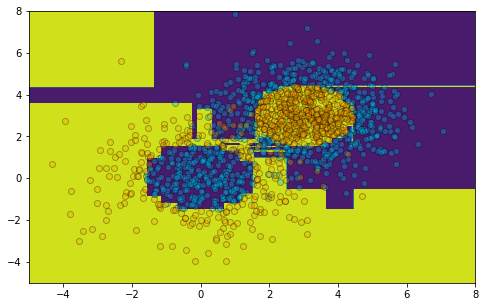

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many(np.c_[xx.ravel(), yy.ravel()], decision_tree.tree_)
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [19]:
def predict_many_step_inplace(positions, tree, array_indexes):
    have_children = tree.children_left[array_indexes] >= 0
    array_indexes_with_children = array_indexes[have_children]
    
    features = tree.feature[array_indexes_with_children]
    thresholds = tree.threshold[array_indexes_with_children]
    left_indexes = tree.children_left[array_indexes_with_children]
    right_indexes = tree.children_right[array_indexes_with_children]

    choosing_left = positions[have_children, features] <= thresholds

    # change the right indexes for which we are choosing left into the corresponding left indexes
    # (it's not linked to the original tree.children_right)
    right_indexes[choosing_left] = left_indexes[choosing_left]

    # and now right_indexes is the right thing to change in the array_indexes
    array_indexes[have_children] = right_indexes

In [20]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
array_indexes = np.zeros(len(positions), np.int64)

In [21]:
predict_many_step_inplace(positions, decision_tree.tree_, array_indexes)
array_indexes

array([1, 1, 1])

In [22]:
def predict_many_inplace(positions, tree):
    array_indexes = np.zeros(len(positions), np.int64)

    for iteration in range(tree.max_depth):
        predict_many_step_inplace(positions, tree, array_indexes)
    
    leaf_decisions = np.argmax(decision_tree.tree_.value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

In [23]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
predict_many_inplace(positions, decision_tree.tree_)

array([1, 0, 1])

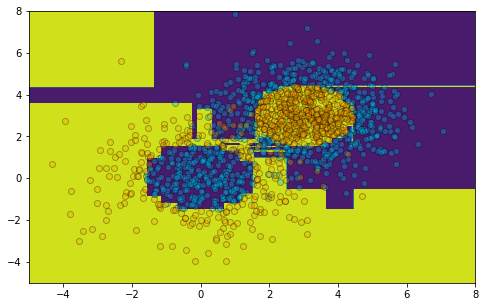

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_inplace(np.c_[xx.ravel(), yy.ravel()], decision_tree.tree_)
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [25]:
prepared_data = np.c_[xx.ravel(), yy.ravel()]

In [26]:
%%timeit -o

decision_tree.predict(prepared_data).reshape(xx.shape)

4.06 ms ± 75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 4.06 ms ± 75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [27]:
result_scikit_learn = _

In [28]:
%%timeit -o

[predict_single(position, decision_tree.tree_) for position in prepared_data]

3.82 s ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 3.82 s ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [29]:
result_python = _

In [30]:
%%timeit -o

predict_many(prepared_data, decision_tree.tree_)

40.3 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 40.3 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [31]:
result_numpy = _

In [32]:
%%timeit -o

predict_many_inplace(prepared_data, decision_tree.tree_)

27 ms ± 87.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 27 ms ± 87.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [33]:
result_numpy_inplace = _

In [34]:
import numba as nb

In [35]:
@nb.njit
def predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, array_index=0):
    has_children = tree_children_left[array_index] >= 0

    if has_children:
        feature = tree_feature[array_index]
        threshold = tree_threshold[array_index]
        left_index = tree_children_left[array_index]
        right_index = tree_children_right[array_index]

        if position[feature] <= threshold:
            return predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, left_index)
        else:
            return predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value, right_index)

    else:
        return np.argmax(tree_value[array_index])

In [36]:
predict_single_numba(
    np.array([-4, -4], np.float64),
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

1

In [37]:
@nb.njit
def predict_many_numba(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value):
    out = np.empty(len(positions), np.int64)
    for index, position in enumerate(positions):
        out[index] = predict_single_numba(position, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value)
    return out

In [38]:
positions = np.array([[-4, -4], [0, 0], [-1, 3]])
predict_many_numba(
    positions,
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

array([1, 0, 1])

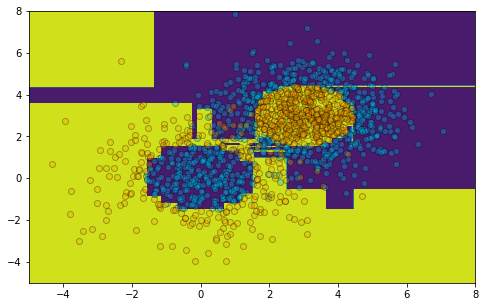

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_numba(
        np.c_[xx.ravel(), yy.ravel()],
        decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
    )
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [40]:
%%timeit -o

predict_many_numba(
    prepared_data,
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

71.3 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 71.3 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [41]:
result_numba = _

In [42]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

In [43]:
def predict_many_step_jax(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, array_indexes):
    have_children = tree_children_left[array_indexes] >= 0

    features = tree_feature[array_indexes]
    thresholds = tree_threshold[array_indexes]
    left_indexes = tree_children_left[array_indexes]
    right_indexes = tree_children_right[array_indexes]

    choosing_left = positions[jax.numpy.arange(len(positions)), features] <= thresholds

    return jax.numpy.where(have_children, jax.numpy.where(choosing_left, left_indexes, right_indexes), array_indexes)

def predict_many_jax(positions, tree_feature, tree_threshold, tree_children_left, tree_children_right, tree_value):
    array_indexes = jax.numpy.zeros(len(positions), np.int64)

    for iteration in range(decision_tree.tree_.max_depth):
        array_indexes = predict_many_step_jax(
            positions,
            tree_feature, tree_threshold, tree_children_left, tree_children_right, array_indexes,
        )
    
    leaf_decisions = jax.numpy.argmax(tree_value, axis=2)[:, 0]

    return leaf_decisions[array_indexes]

predict_many_jax = jax.jit(predict_many_jax, backend="cpu")

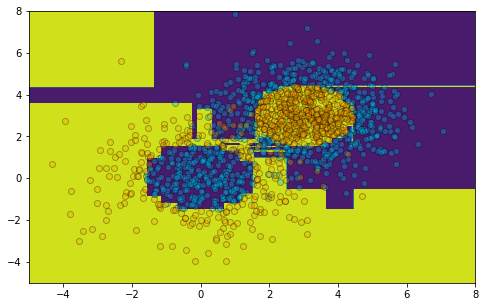

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

xx, yy = np.meshgrid(np.arange(-5, 8, 0.02), np.arange(-5, 8, 0.02))

Z = np.array(
    predict_many_jax(
        np.c_[xx.ravel(), yy.ravel()],
        decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
    )
).reshape(xx.shape)

ax.contourf(xx, yy, Z);
ax.scatter(X[y == 0, 0], X[y == 0, 1], c="deepskyblue", edgecolor="black", alpha=0.3);
ax.scatter(X[y == 1, 0], X[y == 1, 1], c="orange", edgecolor="black", alpha=0.3);
ax.set_xlim(-5, 8);
ax.set_ylim(-5, 8);

In [45]:
%%timeit -o

predict_many_jax(
    prepared_data,
    decision_tree.tree_.feature, decision_tree.tree_.threshold, decision_tree.tree_.children_left, decision_tree.tree_.children_right, decision_tree.tree_.value,
)

4.58 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 4.58 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [46]:
result_jax = _

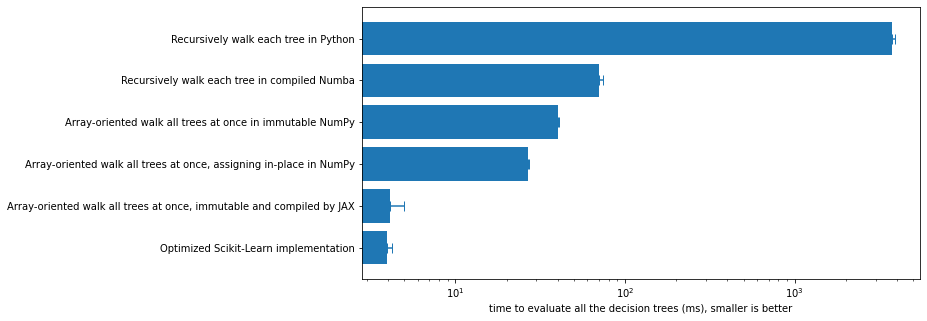

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))

test_names = [
    'Recursively walk each tree in Python',
    'Recursively walk each tree in compiled Numba',
    'Array-oriented walk all trees at once in immutable NumPy',
    'Array-oriented walk all trees at once, assigning in-place in NumPy',
    'Array-oriented walk all trees at once, immutable and compiled by JAX',
    'Optimized Scikit-Learn implementation',
][::-1]
test_results = np.array([
    1e3 * np.min(result_python.all_runs) / result_python.loops,
    1e3 * np.min(result_numba.all_runs) / result_numba.loops,
    1e3 * np.min(result_numpy.all_runs) / result_numpy.loops,
    1e3 * np.min(result_numpy_inplace.all_runs) / result_numpy_inplace.loops,
    1e3 * np.min(result_jax.all_runs) / result_jax.loops,
    1e3 * np.min(result_scikit_learn.all_runs) / result_scikit_learn.loops,
][::-1])
test_variations = np.array([
    1e3 * np.ptp(result_python.all_runs) / result_python.loops,
    1e3 * np.ptp(result_numba.all_runs) / result_numba.loops,
    1e3 * np.ptp(result_numpy.all_runs) / result_numpy.loops,
    1e3 * np.ptp(result_numpy_inplace.all_runs) / result_numpy_inplace.loops,
    1e3 * np.ptp(result_jax.all_runs) / result_jax.loops,
    1e3 * np.ptp(result_scikit_learn.all_runs) / result_scikit_learn.loops,
][::-1])

ax.barh(range(len(test_names)), test_results);
ax.errorbar(test_results + test_variations/2, range(len(test_names)), xerr=test_variations/2, capsize=5, fmt="none", c="#1f77b4");
ax.set_yticks(range(len(test_names)));
ax.set_yticklabels(test_names);
ax.set_xlabel("time to evaluate all the decision trees (ms), smaller is better");
ax.set_xscale("log");
ax.set_ylim(-0.75, len(test_results) - 0.25);